<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/12_minerva_SimCLR-STL10-latent_space_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/12_minerva_SimCLR-STL10-latent_space_vis.ipynb)

# Visualizing Latent Spaces with Pretrained Models and t-SNE

In this notebook, we explore how pretrained backbones organize information by visualizing their latent spaces. 

Using data from a target task and backbones pretrained in previous tutorials, we extract feature representations and apply t-SNE to project them into a 2D space.
This visualization helps us better understand the structure of the learned features and how the models internally separate different classes.

## 1. Introduction

### 1.1 Objective

The objective of this tutorial is to help students understand how to assess the performance of pretrained neural network backbones by using dimensionality reduction techniques to inspect the latent space produced by these backbones with samples from a target dataset.

First, we will extract feature embeddings from a target task dataset using both pretrained and randomly initialized backbones. 
We will then apply t-SNE to reduce these high-dimensional representations into two dimensions for visualization.

By analyzing the resulting 2D plots, we aim to gain insights into how different classes are organized in the feature space, how effectively pretrained models separate categories, and how the latent structure reflects the model’s learned representations.

Key Points Covered:

* Extract features from pretrained and random backbones.

* Apply t-SNE to project high-dimensional representations into 2D.

* Visualize and interpret how models internally organize and differentiate between samples.


### 1.2 What we will cover

We will begin by setting up the target dataset.
Next, we will write code to load backbones pretrained in previous tutorials.
Finally, we will extract features and visualize target dataset samples on 2D charts using t-SNE.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic Setup**](#sec_2) | Import the necessary modules (PyTorch, Torchvision, and PyTorch Lightning), and define the key variables that control the evaluation process.  |
| [**3. Setting Up the Dataset**](#sec_3) | Prepare the target dataset. |
| [**4. Loading Pretrained Backbones**](#sec_4) | Implement code to load backbones pretrained in earlier tutorials. |
| [**5. Evaluating the Backbones**](#sec_5) | Extract features and plot target dataset samples on 2D charts using t-SNE. |
| [**6. Displaying sample images on the plot (Extra)**](#sec_6) | Discuss how to plot sample thumbnails on the 2D charts instead of simple points. |
| [**7. Exercises**](#sec_7) | Suggested Exercises. |

### 1.3 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* Minerva: check the [Minerva docs](https://discovery-unicamp.github.io/Minerva/).

* Lightning: check the [Lightning documentation](https://lightning.ai/docs/overview/getting-started) and research or post Lightning related question on the [PyTorch Lightning forum](https://lightning.ai/forums/).

* PyTorch: check the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

## <a id="sec_2">2. Basic setup</a>

### 2.1 Setting the main variables

* `max_number_of_samples_per_class`: Defines the number of samples per class that will be plotted. Samples are selected randomly. 
This parameter can be adjusted to reduce the time it takes to plot each chart.

In [1]:
## General configuration variables

# Number of samples per class to plot
max_number_of_samples_per_class = 200

### 2.2 Installing Lightining and Minerva modules

The code below attempts to import Minerva and installs it if it is not already available.
Since Minerva depends on the Lightning module, Lightning will also be installed automatically when Minerva is installed.

In [2]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

### 2.3 Importing basic modules

In [3]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import lightning
import lightning

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"Lightning version: {lightning.__version__}")
#print(f"Minerva version: {M.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
Lightning version: 2.5.1


## <a id="sec_3">3. Setting Up the Dataset</a>

### 3.1 Download and instantiate the test dataset

As in previous tutorials, we will use the `torchvision` module to download the test dataset.
Additionally, we will define a data transformation pipeline to convert samples from PIL images to tensors and normalize them using the dataset's mean and standard deviation.

In [4]:
# Torchvision transforms
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Normalize

# STL10 statistics for the test split. 
# - Note: If you would like to compute these statistics for your own dataset, refer 
#         to the discussion in tutorial 05_pytorch_transfer_learning.ipynb.
stl10_test_mean = torch.tensor([0.4472, 0.4396, 0.4050])
stl10_test_std  = torch.tensor([0.2606, 0.2567, 0.2700])

# Build the data transform pipeline to convert from PIL images to tensors and normalize the data. 
transform_pipeline = Compose([
    ToImage(), 
    ToDtype(torch.float32, scale=True),
    Normalize(mean=stl10_test_mean, std=stl10_test_std)
])

# Build the dataset object (This step will download the dataset if it hasn't been previously downloaded).
test_dataset = torchvision.datasets.STL10(root="data", 
                                          split="test",  
                                          download=True,
                                          transform=transform_pipeline)

class_names = test_dataset.classes
print("Class names:", class_names)

Class names: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


### 3.2 Filtering the dataset

In [5]:
from torch.utils.data import Subset
import random

def sample_dataset(dataset, max_number_of_samples_per_class):
    indices = {}

    # Group samples indices by label.
    for i in range(len(dataset)):
        _, label = dataset[i]
        if not label in indices: indices[label] = []
        indices[label].append(i)

    # For each label, select a subset of at most max_number_of_samples_per_class samples. 
    selected_indices = []
    for k, v in indices.items():
        selected_indices.extend(v[:min(max_number_of_samples_per_class, len(v))])

    # Shuffle the indices list
    random.shuffle(selected_indices)

    return Subset(dataset, selected_indices)

In [6]:
filtered_dataset = sample_dataset(test_dataset, max_number_of_samples_per_class)

## <a id="sec_4">4. Loading Pretrained Backbones</a>

This section contains code to load pretrained backbones.

As we already discussed how to load pretrained backbones in tutorial `10_minerva_SimCLR-STL10-downstream_task.ipynb`, we will simply copy and paste the code here.


In [7]:
from torchvision.models import resnet18

def generate_backbone(weights=None):
    backbone = resnet18(weights=weights)
    backbone.fc = torch.nn.Identity()
    return backbone

def generate_proj_head(backbone_out_dim=512, output_dim=128):
    return torch.nn.Sequential(
        torch.nn.Linear(backbone_out_dim, 4*output_dim), # Resnet output => 4*hidden_dim
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(4*output_dim, output_dim))

In [8]:
from minerva.models.ssl.simclr import SimCLR

def loadPretrainedBackbone(ckpt_filename):
    pretext_model = SimCLR.load_from_checkpoint(ckpt_filename,
                                                backbone=generate_backbone(),
                                                projection_head=generate_proj_head())
    return pretext_model.backbone

## <a id="sec_5">5. Evaluating the backbones</a>

Now, we will load pretrained backbones and evaluate them by examining how they organize the test dataset samples in the latent space.
To do this, we will extract features from the test samples using the backbone and apply t-SNE to project them into a 2D space.

### 5.1 Extracting features

First, let's implement a function to extract the features of the samples using a given backbone.

For each sample in the dataloader, this function encodes the original features using the backbone and stores the features on an numpy array.

In [9]:
import numpy as np

def extract_features(backbone, dataset):
    backbone.eval()
    features_list = []
    labels_list = []
    with torch.no_grad():
        # For each batch
        for original_features, label in dataset:
            # Send the features to the computing device
            original_features = original_features.to(next(backbone.parameters()).device)
            # Encode the sample using the backbone
            features = backbone(original_features.unsqueeze(0))
            features_list.append(features.squeeze(0).cpu().numpy())
            labels_list.append(label)
    # Return two numpy arrays, one with the dataset features and another with the dataset labels.
    return np.stack(features_list), np.stack(labels_list)

### 5.2 Plotting Samples on 2D chart

In [10]:
import plotly.express as px

# Function to plot data
def plot_samples_plotly(features, labels, title):
    y_str = [class_names[i.item()] for i in labels]
    samples_indices = list(range(len(y_str)))
    fig = px.scatter(x=features[:,0], y=features[:,1], 
                    color=y_str, 
                    hover_name=y_str,
                    hover_data={"Image index": samples_indices})
    fig.update_layout(title=title)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.show()

### 5.3 Downloading Minerva SimCLR checkpoints

We will use checkpoints generated by SimCLR in the tutorial `09_minerva_SimCLR-STL10-backbone_pretrain.ipynb`.

If you did not save your own checkpoints, you can download a pre-generated set that I have made available on my webpage.
For convenience, the code below will automatically download and extract the checkpoints.

This particular zip file contains model checkpoints saved every 20 epochs.

In [11]:
import os
filename = '09_minerva_SimCLR_STL10-checkpoints-20-100.zip'

if not os.path.exists(filename):
    # Download the zip file with checkpoints
    import urllib.request
    print(f"Downloading {filename}")
    url = 'https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/09_minerva_SimCLR_STL10-checkpoints-20-100.zip'
    urllib.request.urlretrieve(url, filename)

if not os.path.exists("logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/"):
    # Unzip the checkpoint file
    import zipfile
    print(f"Extracting {filename}")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

### 5.4 Load the Backbones

Now, let's load the pretrained backbones. We will also add two extra backbones, one that was not trained and another that was pretrained with ImageNet.

In [12]:
from torchvision.models import resnet18, ResNet18_Weights
import glob

# List of backbones to evaluate
backbones = []

# Search for the checkpoints generated by SimCLR in tutorial 09
simclr_ckpt_files = glob.glob("logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=*")

# For each checkpoint file.
for i, ckpt_filename in enumerate(simclr_ckpt_files):
    print(f"==== {len(backbones):3d} {ckpt_filename} ====")

    backbone = loadPretrainedBackbone(ckpt_filename)

    # Extract basename and epoch info from checkpoint path
    info = ckpt_filename.split("/") 
    checkpoint_filename = info[7]
    epoch_info = checkpoint_filename.split("-")[0]
    epoch_number = int(epoch_info.split("=")[1])

    backbone_basename = f"SimCLR-{epoch_info}"

    backbones.append({
        "basename": backbone_basename,
        "epoch number": epoch_number,
        "ckpt_filename": ckpt_filename,
        "backbone": backbone
    })

# Add the random backbone
backbones.append({
    "basename": "Random",
    "epoch number": 0,
    "ckpt_filename": "None",
    "backbone": generate_backbone()
})

# Add the backbone pretrained with ImageNet 
backbones.append({
    "basename": "ImageNet",
    "epoch number": 10000, # Large number so it is last after sorting by epoch number.
    "ckpt_filename": "None",
    "backbone": generate_backbone(weights=ResNet18_Weights.DEFAULT)
})

# Sort list according to epoch number
backbones = sorted(backbones, key = lambda i: i["epoch number"])

print("List of backbones:", [ i["basename"] for i in backbones])

====   0 logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=19-step=6260.ckpt ====
====   1 logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=79-step=25040-v1.ckpt ====
====   2 logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=39-step=12520.ckpt ====
====   3 logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=98-step=30987.ckpt ====
====   4 logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=59-step=18780.ckpt ====
====   5 logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=99-step=31300.ckpt ====
List of backbones: ['Random', 'SimCLR-epoch=19', 'SimCLR-epoch=39', 'SimCL

### 5.4 Evaluate the Backbones

Before we begin, let's configure the Plotly renderer.
To display interactive charts directly in your notebook, set `pio.renderers.default` to `"jupyterlab"` or `"vscode"`, depending on your environment.
You can view all available renderers on your system by printing the `pio.renderers` variable.

> **Hint**: Interactive Plotly charts let you explore the data by hovering over sample points to reveal detailed information.

In [13]:
# Configure the plotly renderer to use jupyterlab - you might print the 
# contents of the pio.renderers variable to check for other available 
# renderers (examples include: vscode, png, jpeg, pdf, ...)
import plotly.io as pio
pio.renderers.default = "png"
#print(pio.renderers)
#pio.renderers.default = "jupyterlab"

** Backbone Random **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


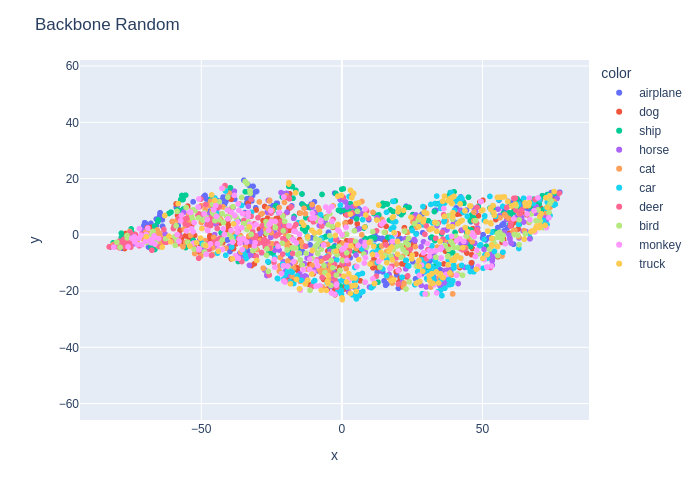

** Backbone SimCLR-epoch=19 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


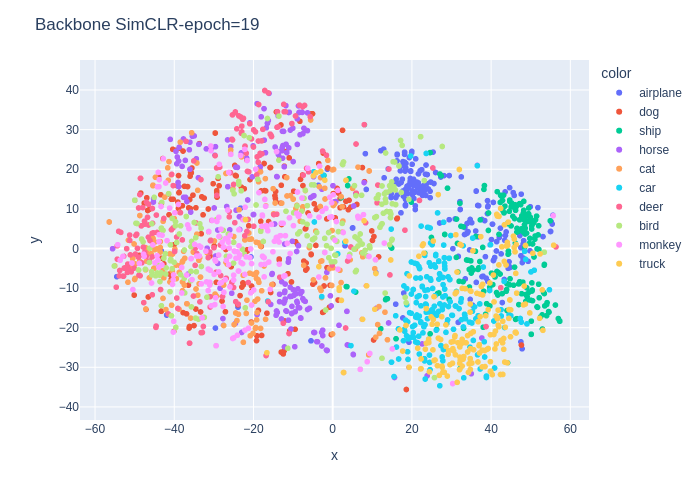

** Backbone SimCLR-epoch=39 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


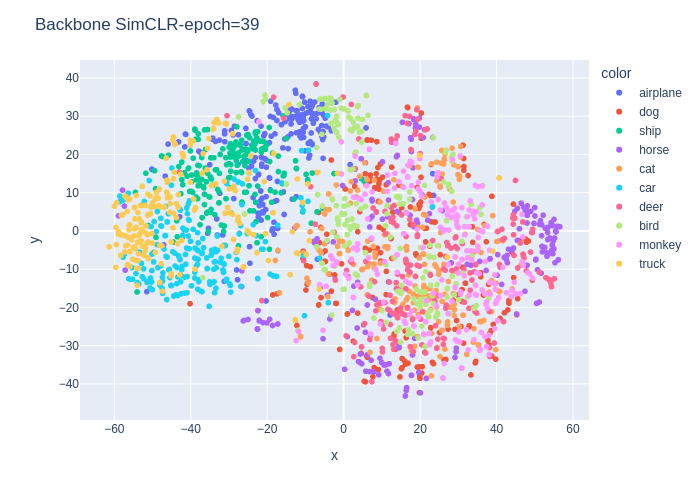

** Backbone SimCLR-epoch=59 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


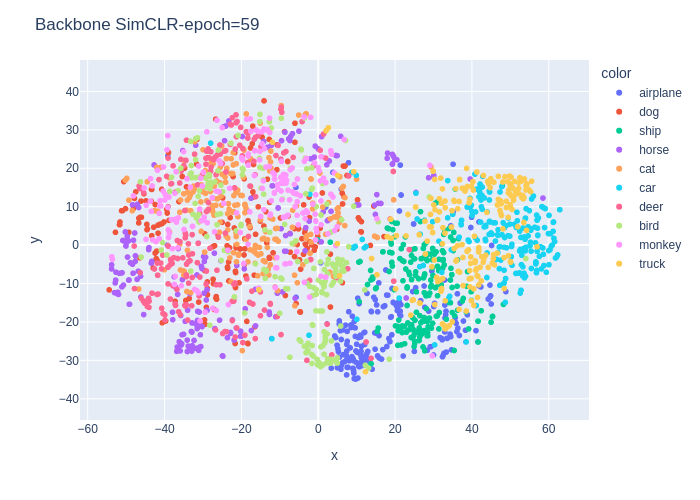

** Backbone SimCLR-epoch=79 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


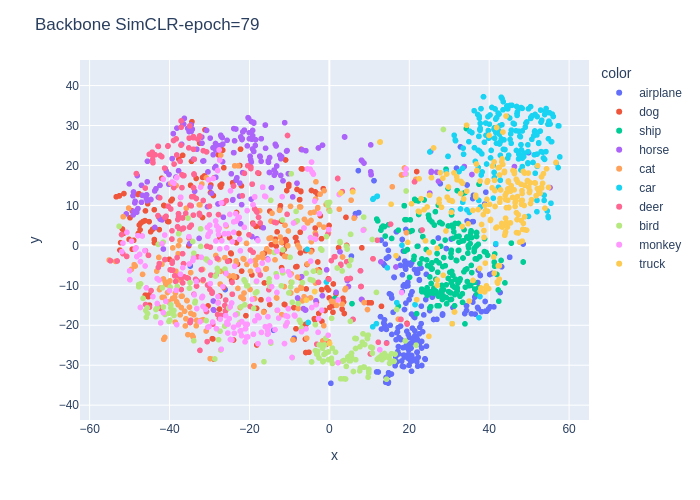

** Backbone SimCLR-epoch=98 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


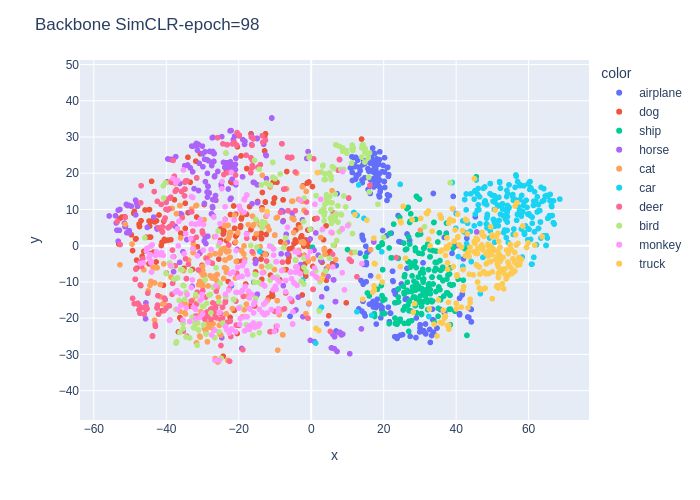

** Backbone SimCLR-epoch=99 **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


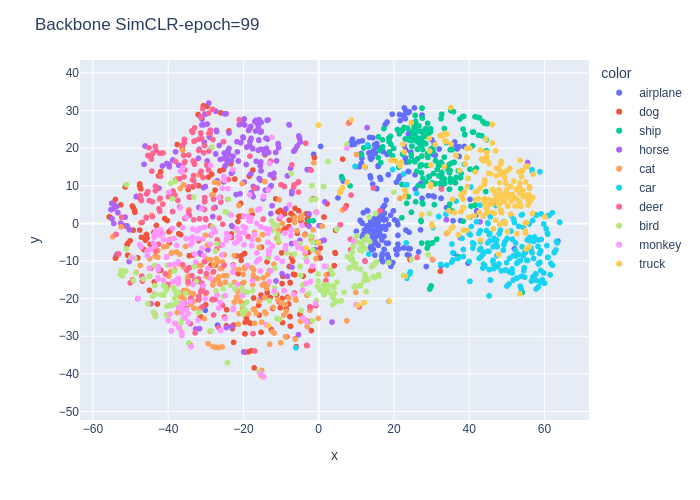

** Backbone ImageNet **
- Extracting features...[Done]
- Projecting with t-SNE...[Done]
- Plotting the chart.


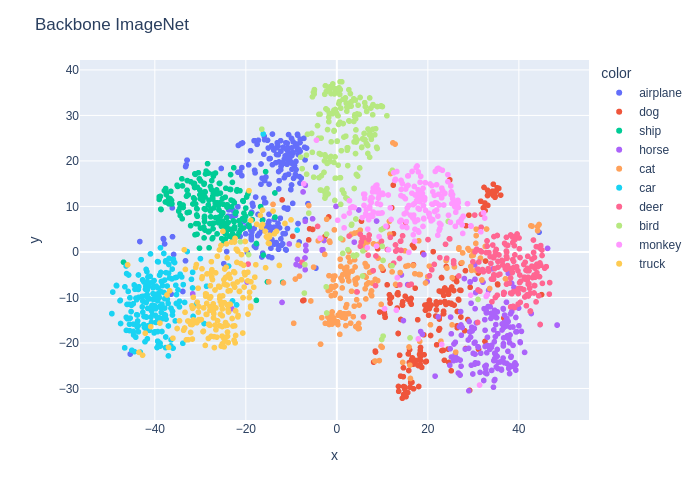

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) # , perplexity=100)

for backbone_info in backbones:
    basename = backbone_info["basename"]
    print(f"** Backbone {basename} **")
    
    print("- Extracting features...", end="")
    backbone = backbone_info["backbone"]
    learned_features, labels = extract_features(backbone, filtered_dataset)

    print("[Done]\n- Projecting with t-SNE...", end="")
    tsne_features = tsne.fit_transform(learned_features)

    print("[Done]\n- Plotting the chart.")
    plot_samples_plotly(tsne_features, labels, f"Backbone {basename}")

The plots illustrate how the representations learned by SimCLR evolve over the epochs, showing progressively improved class separation.
Specifically, SimCLR demonstrates strong performance in distinguishing machinery-related classes (e.g., airplane, ship) from animal classes (e.g., deer, cat).
Moreover, the model appears to cluster machinery samples more tightly than animal samples, indicating greater feature cohesion for machinery-related categories.

Finally, it is worth noting that the backbone pretrained on ImageNet exhibits very strong clustering behavior, organizing samples clearly according to their respective classes.


## <a id="sec_6">6. Displaying sample images on the plot (Extra)</a>

Sometimes it is usefull to plot the image itself instead of a point representing the sample. 
In this section, we will explore how to use matplotlib to annotate the plots with sample images.
To illustrate this concept, we will use the backbone pre-trained with ImageNet samples.

Let's instantiate the backbone.

In [15]:
backbone = generate_backbone(weights=ResNet18_Weights.DEFAULT)

These plots can consume a significant amount of memory and generate large output files. 
To manage memory usage and file size, we will limit the maximum number of samples plotted. 
To do so, we will employ the `sample_dataset()` function, implemented above.

In [16]:
small_dataset = sample_dataset(test_dataset, max_number_of_samples_per_class=10)

### 6.1 Extracting Features and Projecting them into a 2D Space with t-SNE

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2) # , perplexity=100)

learned_features, labels = extract_features(backbone, small_dataset)

tsne_features = tsne.fit_transform(learned_features)

### 6.2 Generating the `numpy` Images

In [18]:
denormalize = Compose([Normalize(mean=torch.tensor([0.0,0.0,0.0]), std=1/stl10_test_std),
                       Normalize(mean=-stl10_test_mean, std=torch.tensor([1.0,1.0,1.0]))])

def extract_numpy_image_list(dataset):
    images_list = [ ]
    for img, _ in dataset:
        img = denormalize(img)
        img = img.permute(1,2,0)
        images_list.append(img.numpy())
    return images_list

numpy_images_list = extract_numpy_image_list(small_dataset)

numpy_images_list[0].shape

(96, 96, 3)

### 6.3 Plotting Images on the Chart

To plot images on the chart, we will use Matplotlib’s `AnnotationBbox` and `OffsetImage` utilities.

The `OffsetImage` function creates image objects from `numpy` arrays, while `AnnotationBbox` places these images at specified locations on the chart.
The following code defines a function that takes a list of numpy images and plots them over the corresponding points.

In [19]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_samples_matplotlib_annotated(tsne_features, # numpy array with samples tSNE features 
                                      labels,  # numpy array with samples labels
                                      numpy_images_list=None, # list with numpy images to plot. If None, no images will be plotted
                                      title=None, # Chart title. If None, no title will be displayed
                                      output_file_basename=None, # Basename for the output pdf file - If None, not file will be produced
                                      img_size_factor=1.0, # Image size factor - control the size of the images.
                                      figsize=(20,20), # Control the matplotlib chart size.
                                      show_image=True,
                                      ):

    fig, ax = plt.subplots(figsize=figsize)
    str_labels = [class_names[i] for i in labels]
    scatter = ax.scatter(tsne_features[:,0], tsne_features[:,1], c=labels, cmap='jet')

    if not numpy_images_list:
        #legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Class")
        le = scatter.legend_elements()
        new_le = (le[0], [class_names[i] for i in range(len(le[1]))])
        legend1 = ax.legend(*new_le, loc="upper left", title="Class")
        ax.add_artist(legend1)

    if title:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.grid(False)

    if not numpy_images_list is None:
        # For each image, plot it on the chart using the t-SNE components as coordinates.
        for i in range(len(numpy_images_list)): 
            np_image = numpy_images_list[i]
            #print(np_image.shape)
            #print(tsne_pos.shape)
            imagebox = OffsetImage(np_image, zoom=img_size_factor)
            imagebox.image.axes = ax
            ab = AnnotationBbox(imagebox, tsne_features[i], xycoords='data', frameon=False)
            ax.add_artist(ab)

    if output_file_basename:
        plt.savefig(f"tsne-{output_file_basename}.pdf", format="pdf") # , bbox_inches="tight")

    if show_image:
        plt.show()

First, let's plot the chart with only the points, as we did before.
To do this, simply omit the list of `numpy` images when calling the plot function.

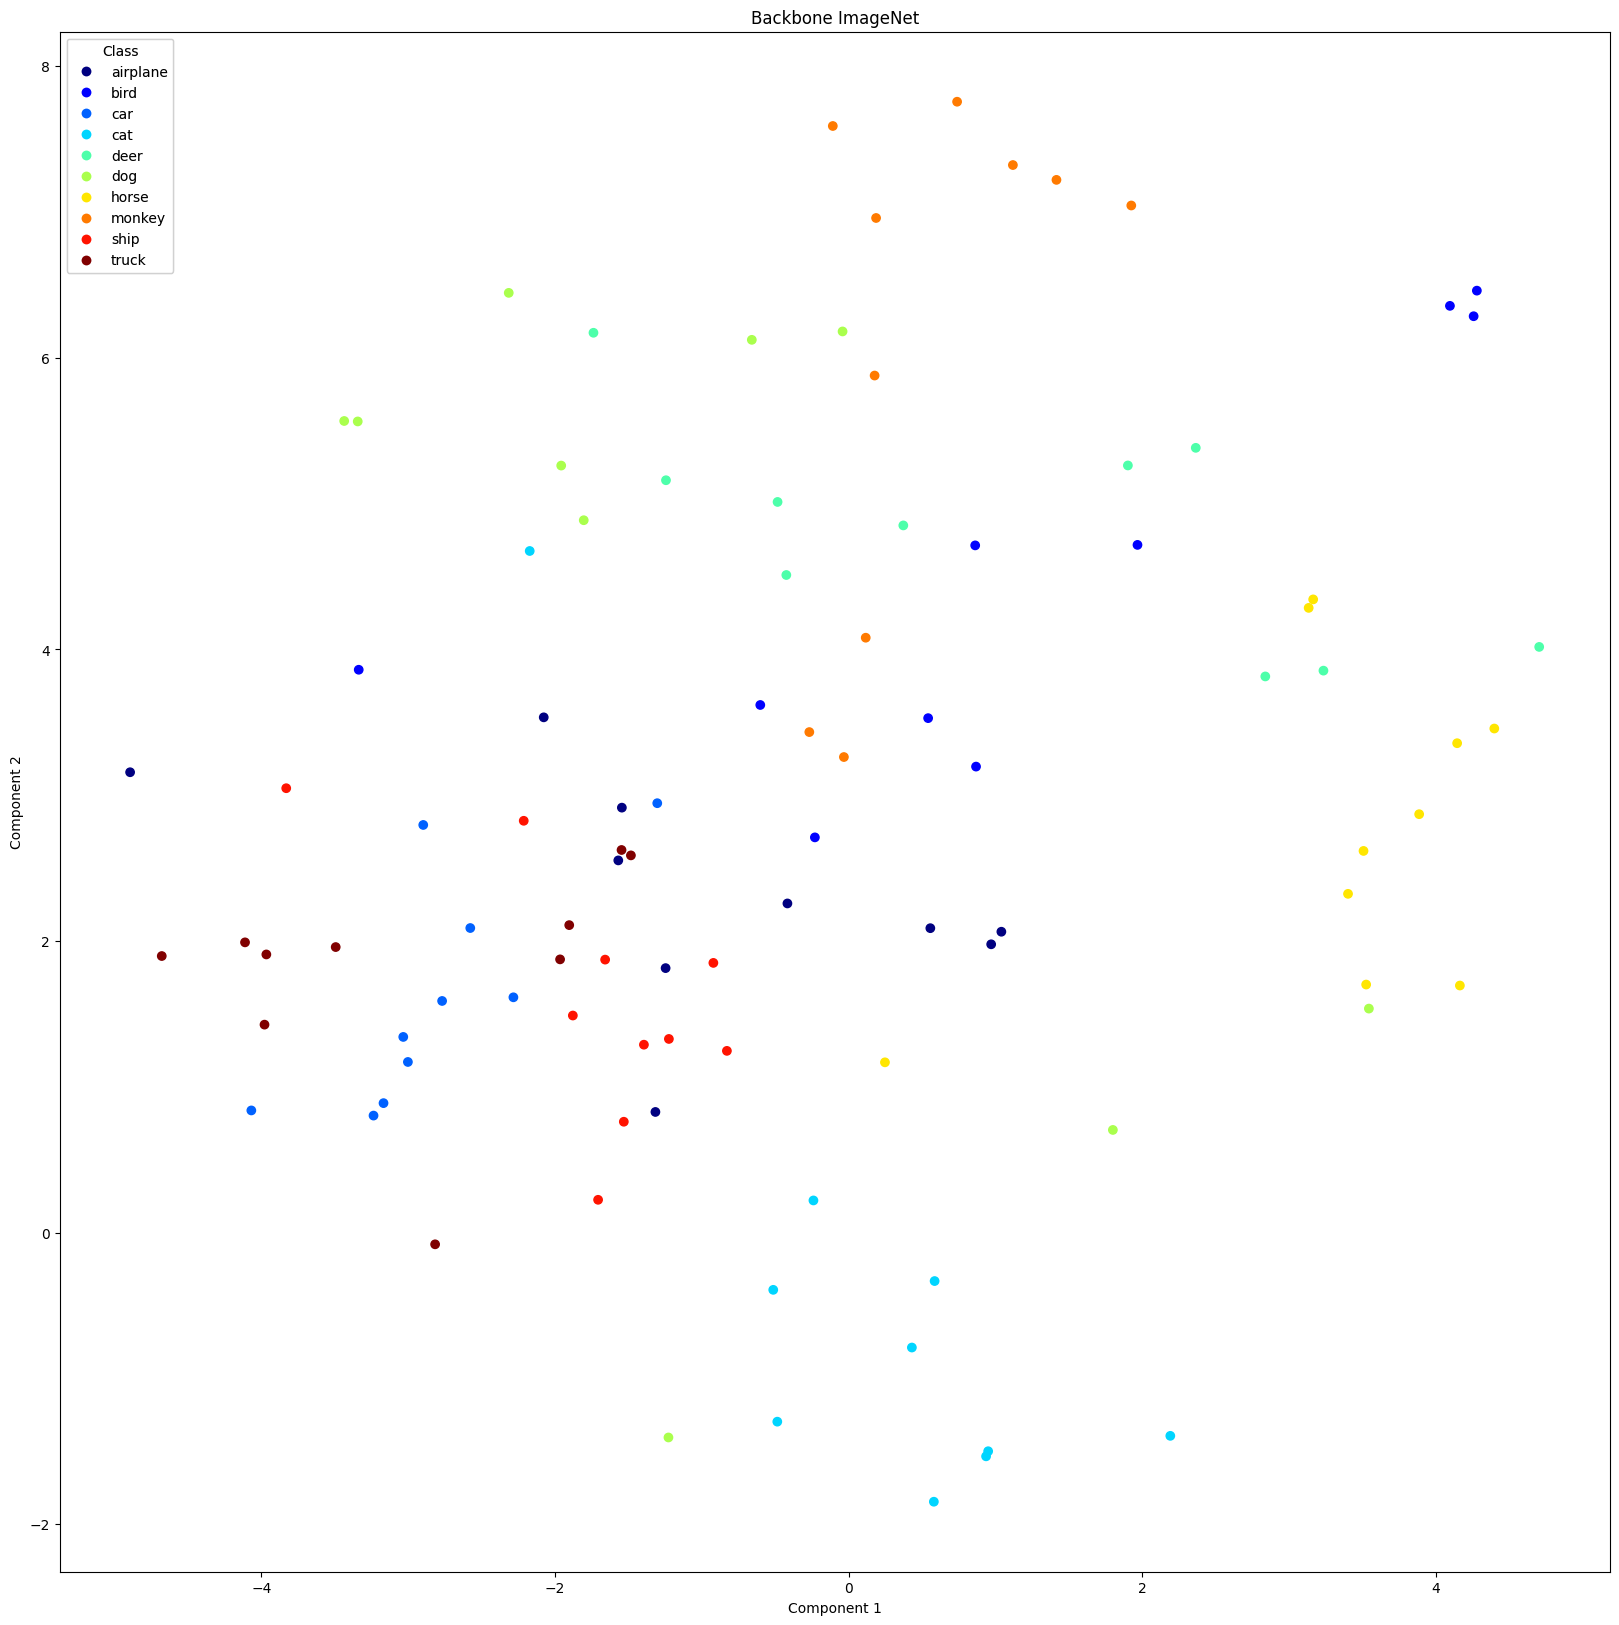

In [20]:
plot_samples_matplotlib_annotated(tsne_features=tsne_features, labels=labels, title=f"Backbone {basename}")

Now, let's plot the chart again but with images on top of each point.

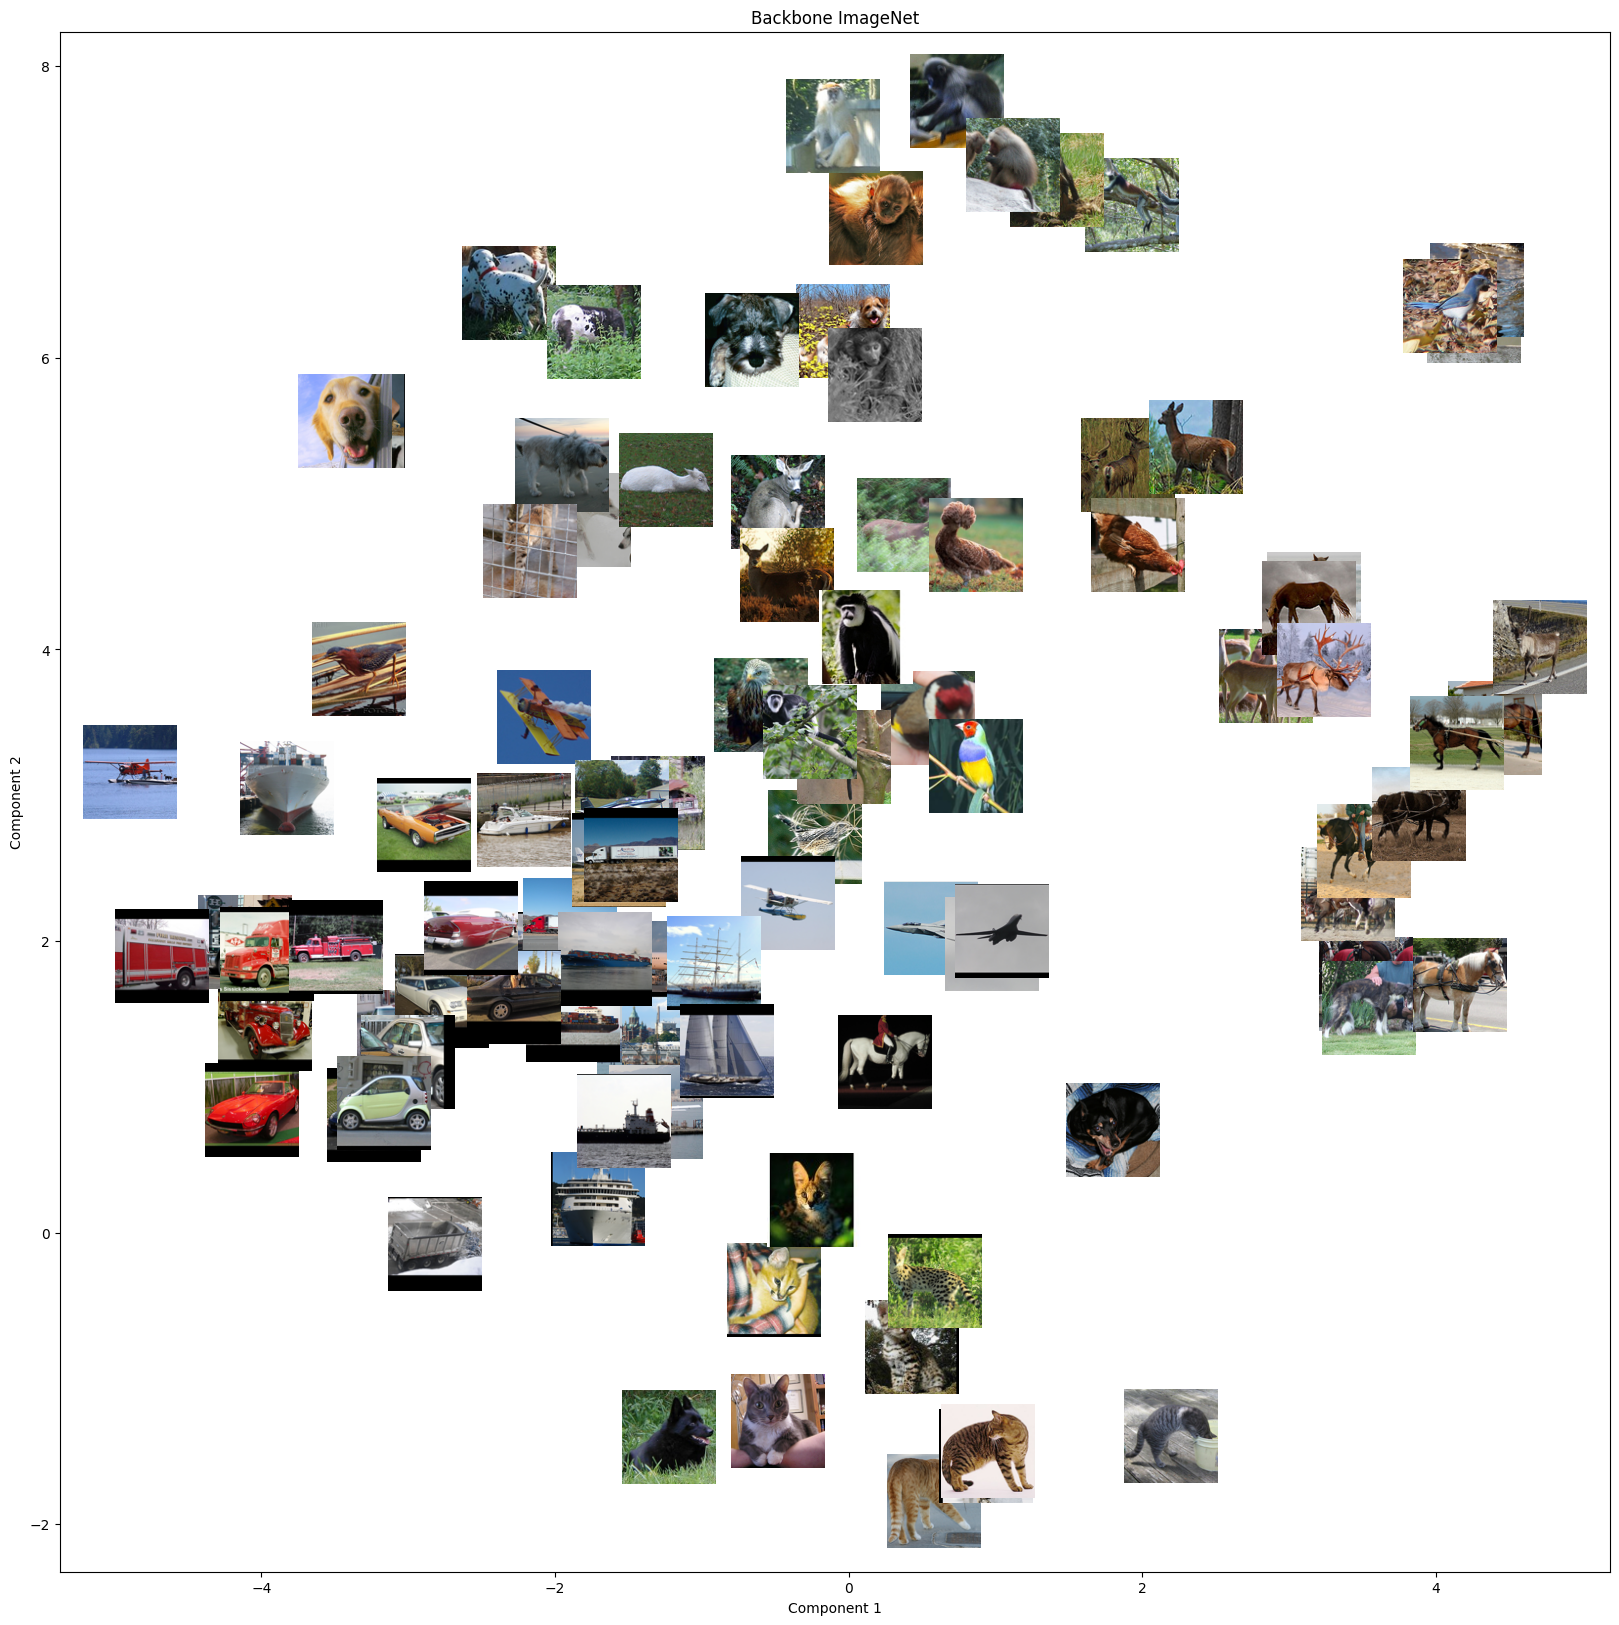

In [21]:
plot_samples_matplotlib_annotated(tsne_features=tsne_features, labels=labels, 
                                  numpy_images_list=numpy_images_list,
                                  title=f"Backbone {basename}", img_size_factor=0.7)

You can play with the `figsize` and `img_size_factor` parameters to adjust the plot to your needs. 
Also, you might set the `output_file_basename` parameter to generate an output PDF file.

## <a id="sec_7">7. Exercises</a>

### 7.1 Inspecting Local Subspaces

In this exercise you must write a function that takes a dataset, a backbone, and a sample index as inputs, and visualizes the latent space around the selected sample.

The steps are as follows:

* First, encode all the samples using the backbone to obtain their feature representations.

* Next, select a subset of samples to plot along with the chosen sample. To do this, compute the distances from the selected sample to all other samples and select the N closest ones (N can be a parameter to your function).

* Then, compute the t-SNE components using the encoded features and the corresponding numpy images.

* Finally, plot the resulting 2D chart displaying the selected subset.